In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
from lib.render.utils import visualize_image
from lib.render.camera import Camera
from lib.render.renderer import DeepSDFNormalRender
from lib.models.siamese import Siamese

sphere_eps = 3e-2
azim = 0
elev = -45
dist = 4

ckpt_path = "/home/borth/sketch2shape/logs/save/deepsdf.ckpt"
siamese_ckpt_path = "/home/borth/sketch2shape/logs/save/siamese/checkpoints/last.ckpt"
save_path = f"/home/borth/sketch2shape/temp/data/{azim}-{-elev}-{dist}-normal.png"

camera = Camera(azim=azim, elev=elev, dist=dist, sphere_eps=sphere_eps)
points, rays, mask = camera.unit_sphere_intersection_rays()
model = DeepSDFNormalRender(
    ckpt_path=ckpt_path,
    shininess=0.0,
    ambient=0.3,
    diffuse=0.3,
    resolution=256,
    prior_idx=37,
    n_render_steps=100,
    surface_eps=1e-03,
    step_scale=1.5,
    sphere_eps=sphere_eps,
)
siamese = Siamese.load_from_checkpoint(siamese_ckpt_path)
siamese.freeze()
siamese.eval()
device = model.model.device

/home/borth/miniconda3/envs/pytorch3d/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/borth/miniconda3/envs/pytorch3d/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/borth/miniconda3/envs/pytorch3d/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.


RuntimeError: Error(s) in loading state_dict for DeepSDF:
	size mismatch for lat_vecs.weight: copying a param with shape torch.Size([3282, 256]) from checkpoint, the shape in current model is torch.Size([1, 256]).

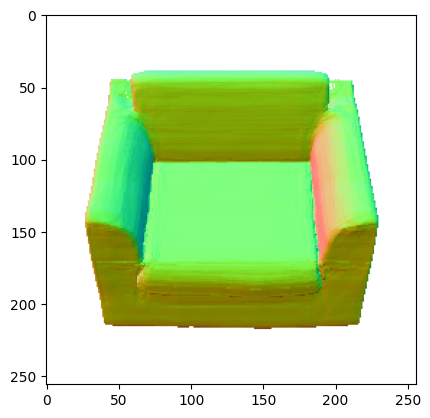

True

In [3]:
surface_points, surface_mask = model.sphere_tracing(
    points=points.to(device),
    rays=rays.to(device),
    mask=mask.to(device),
)
normals = model.render_normals(points=surface_points, mask=surface_mask)
normal_image = visualize_image(model.normal_to_image(normals, surface_mask))
cv2.imwrite(save_path, cv2.cvtColor(normal_image * 255, cv2.COLOR_RGB2BGR))

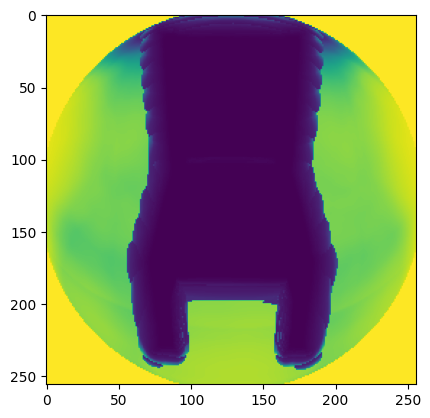

In [6]:
import matplotlib.pyplot as plt

min_points, surface_mask = model.sphere_tracing_min_sdf(
    points=points.to(device),
    rays=rays.to(device),
    mask=mask.to(device),
)
min_sdf = model.forward(points=min_points)
plt.imshow(model.to_image(min_sdf).detach().cpu().numpy())

In [ ]:
mesh = model.to_mesh(resolution=128)
mesh.show()

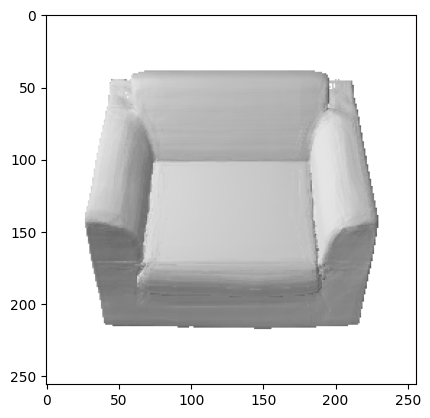

In [8]:
import torch

light_position = torch.tensor([1, 1, 0], dtype=torch.float32, device=device)
surface_points, surface_mask = model.sphere_tracing(
    points=points.to(device),
    rays=rays.to(device),
    mask=mask.to(device),
)
image = model.render_image(
    points=surface_points,
    mask=surface_mask,
    camera_position=camera.camera_position().to(device),
    light_position=light_position,
)
gt_rendered_image = model.to_image(image, surface_mask)
_ = visualize_image(gt_rendered_image)

In [23]:
(gt_rendered_image.detach().cpu().numpy() * 255).astype(np.uint8)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

  0%|          | 0/30 [00:00<?, ?it/s]/home/borth/sketch2shape/lib/render/utils.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deg = torch.deg2rad(torch.tensor(deg))
/home/borth/sketch2shape/lib/render/utils.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deg = torch.deg2rad(torch.tensor(deg))


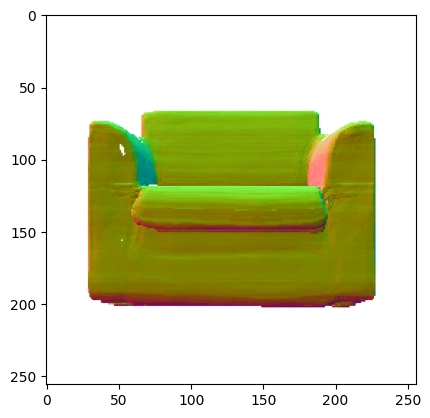

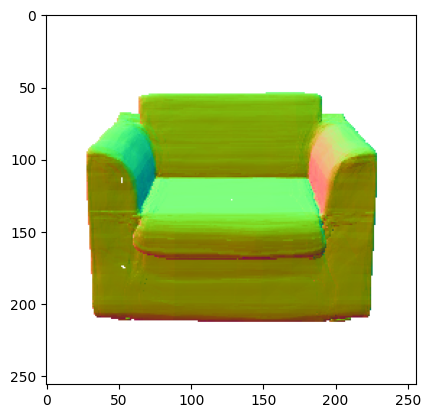

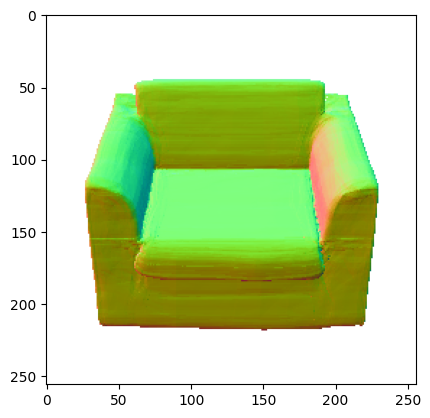

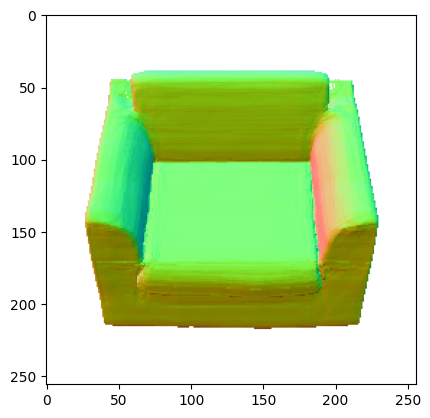

  3%|▎         | 1/30 [00:02<01:05,  2.27s/it]

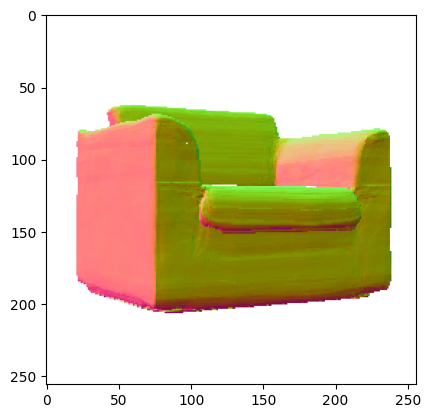

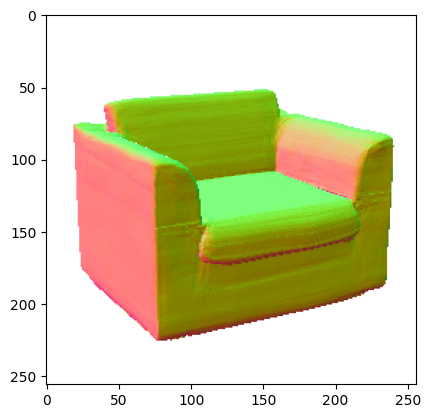

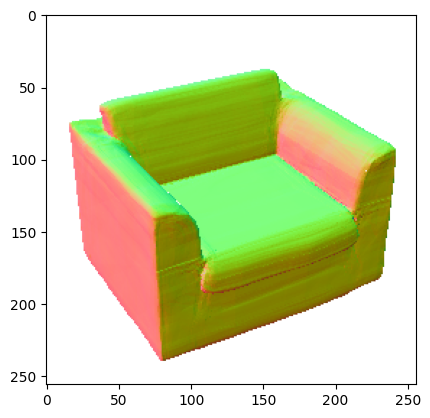

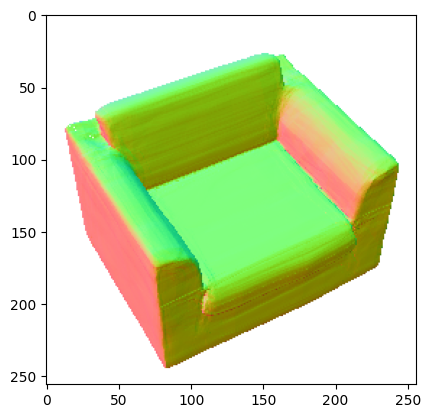

  7%|▋         | 2/30 [00:04<01:01,  2.21s/it]

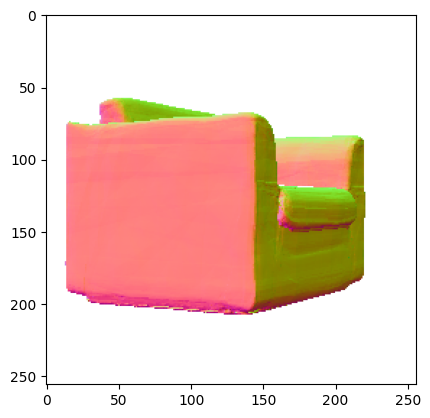

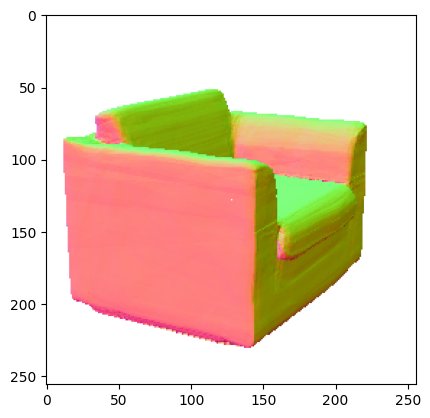

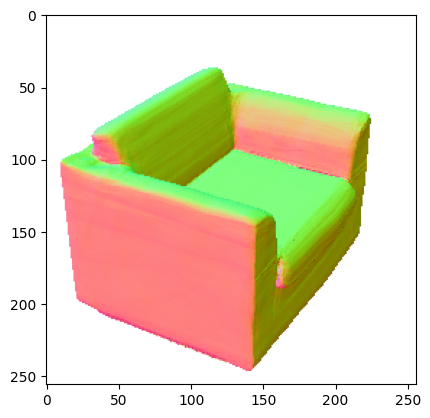

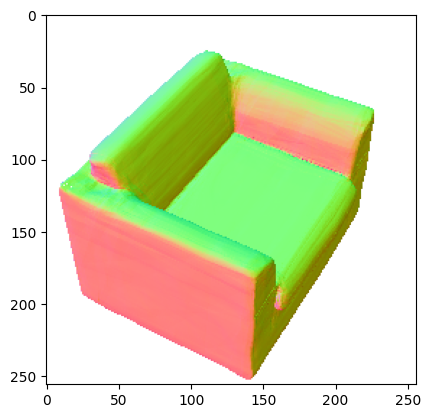

 10%|█         | 3/30 [00:06<00:58,  2.16s/it]

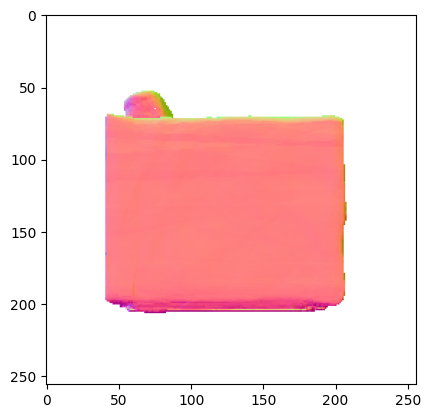

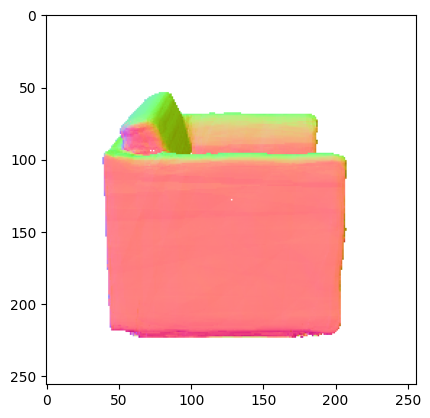

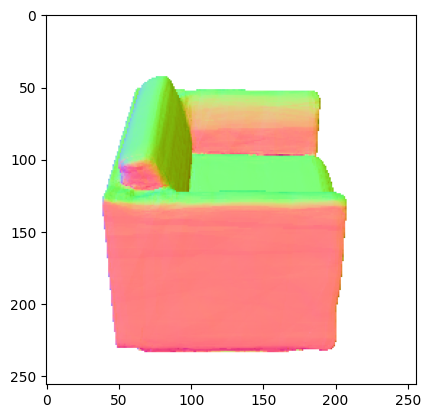

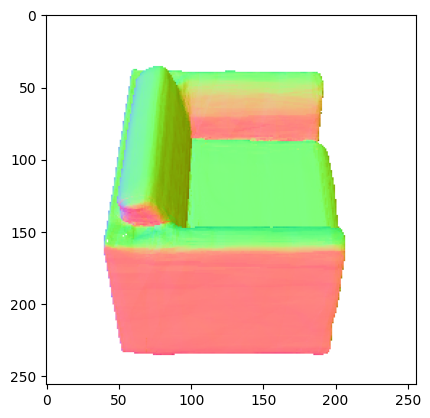

 13%|█▎        | 4/30 [00:08<00:57,  2.21s/it]

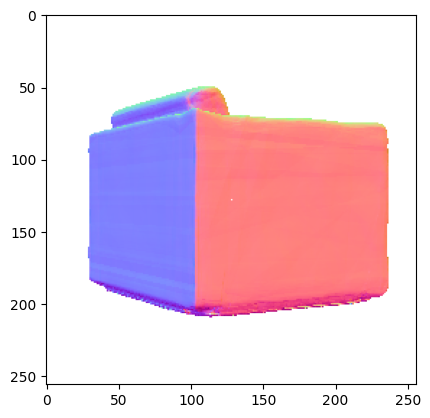

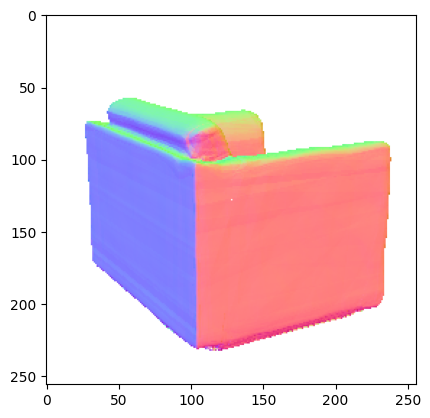

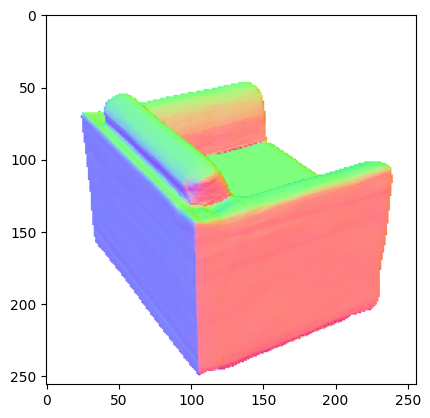

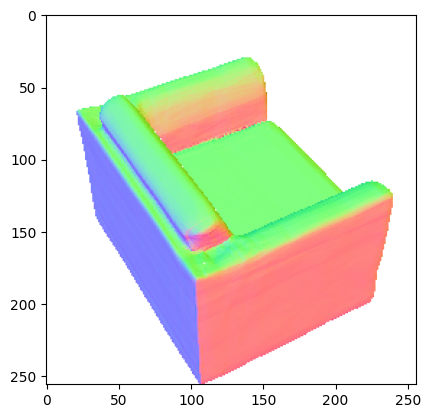

 17%|█▋        | 5/30 [00:10<00:54,  2.18s/it]

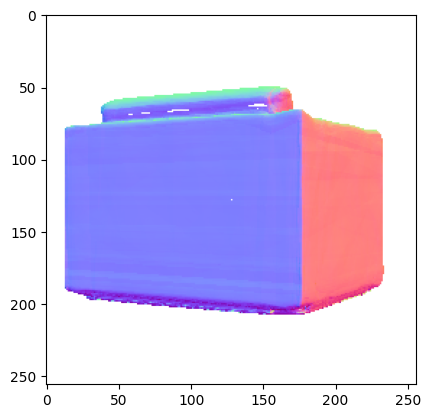

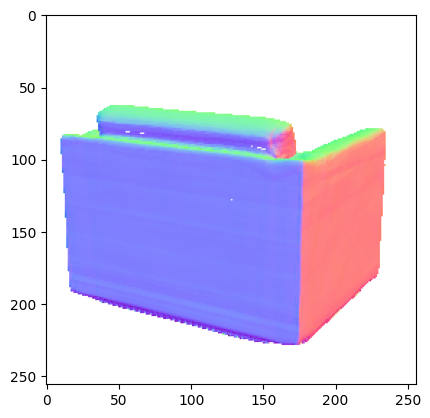

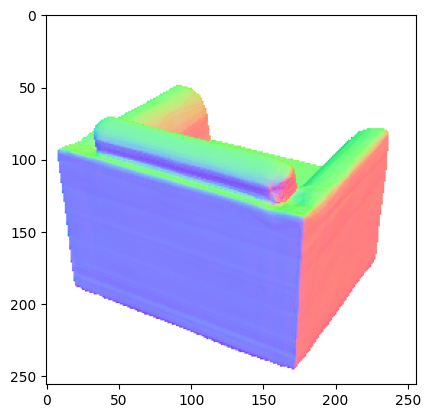

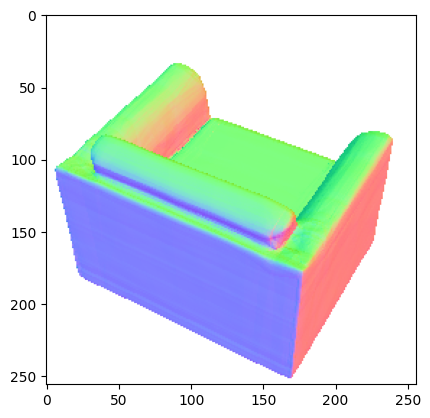

 20%|██        | 6/30 [00:13<00:51,  2.16s/it]

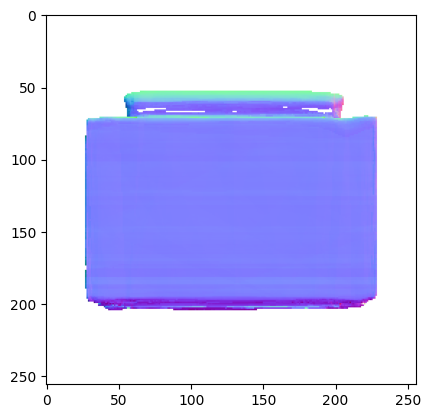

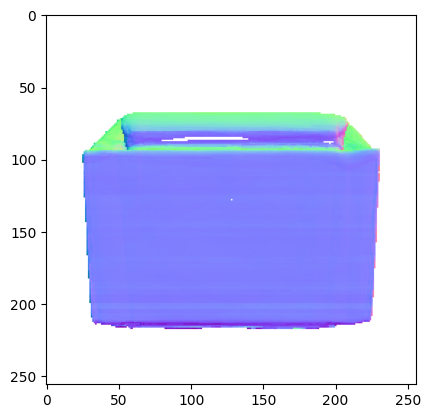

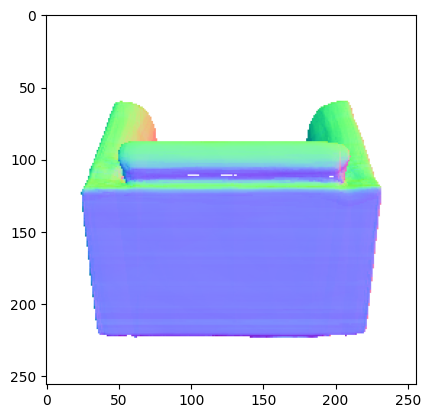

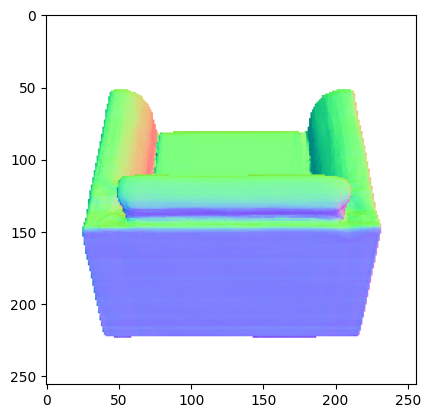

 23%|██▎       | 7/30 [00:15<00:48,  2.13s/it]

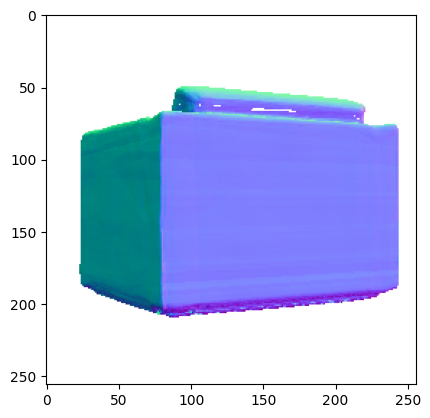

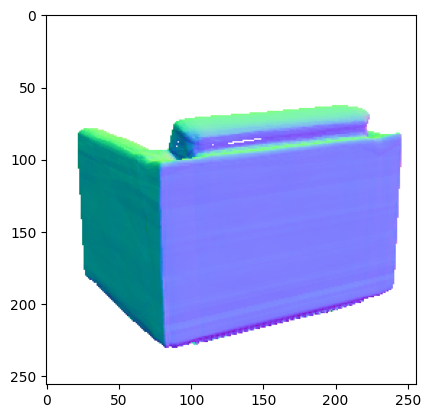

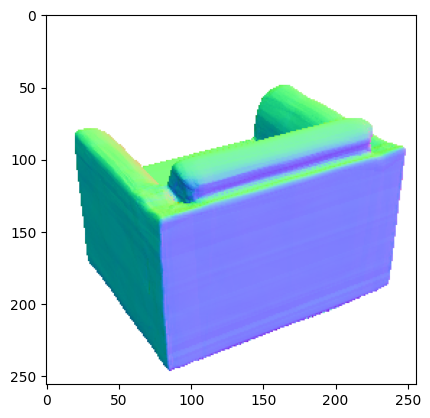

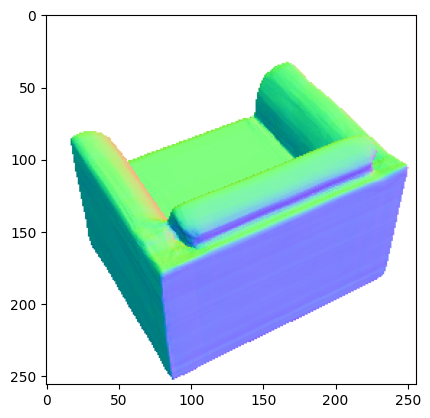

 27%|██▋       | 8/30 [00:17<00:46,  2.13s/it]

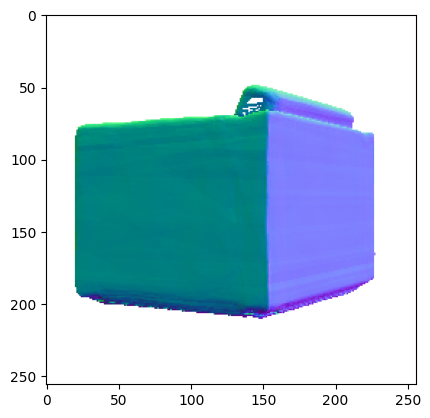

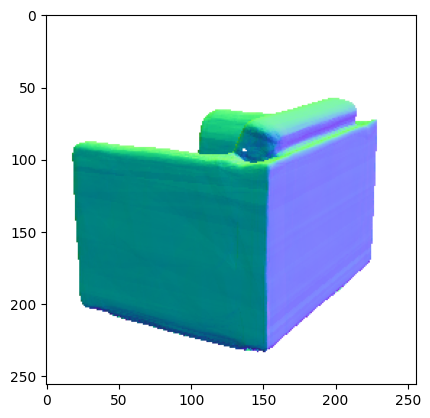

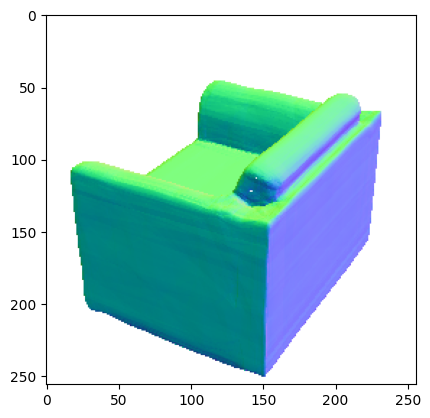

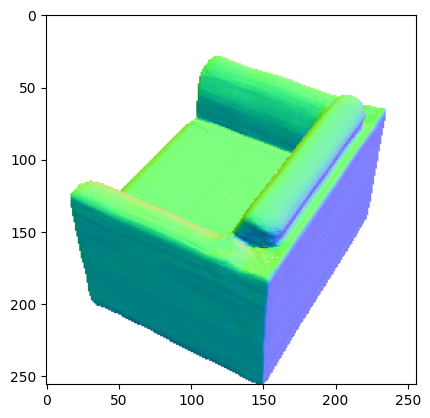

 30%|███       | 9/30 [00:19<00:45,  2.15s/it]

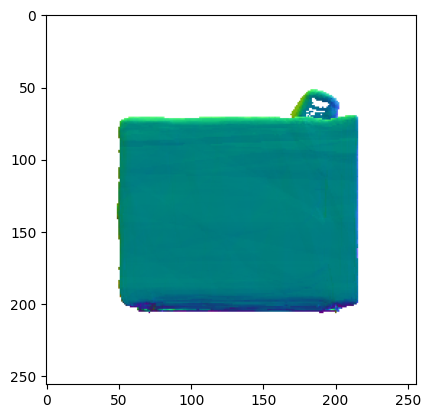

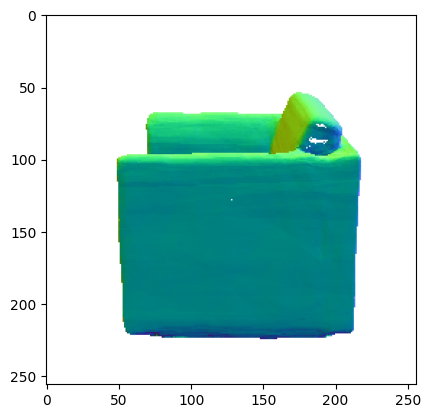

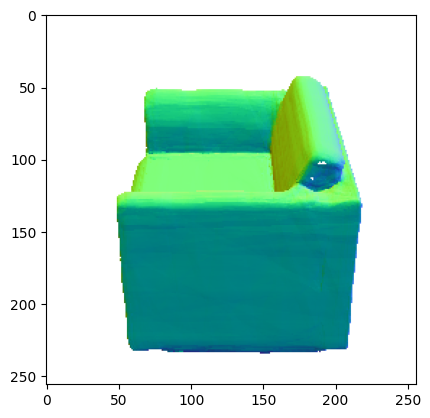

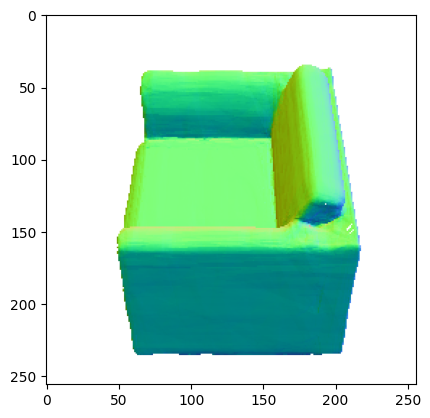

 33%|███▎      | 10/30 [00:21<00:43,  2.16s/it]

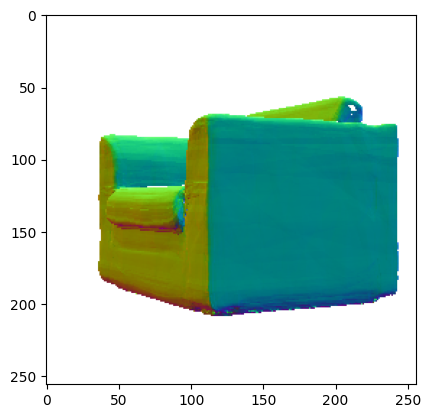

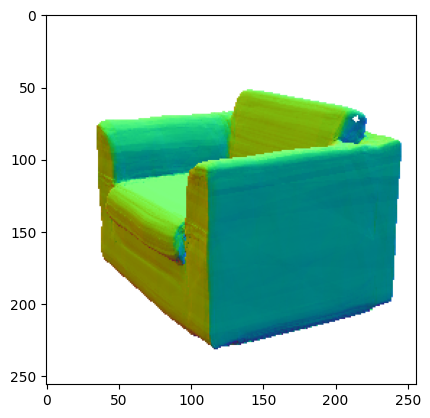

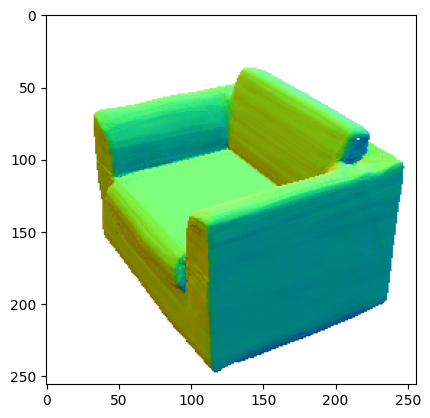

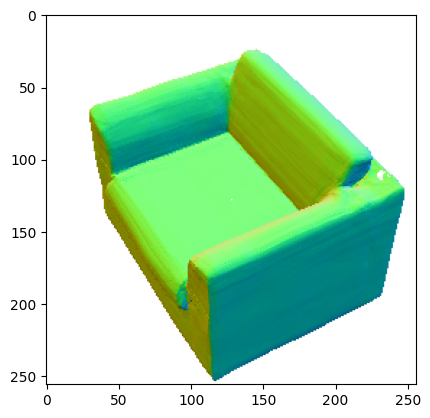

 37%|███▋      | 11/30 [00:23<00:41,  2.19s/it]

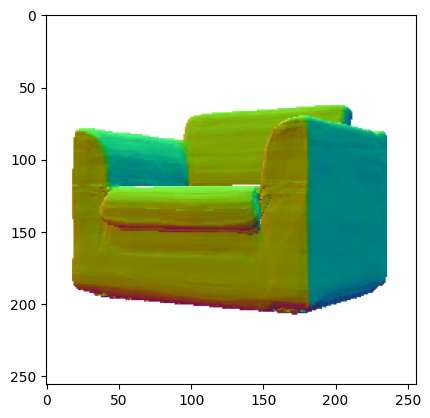

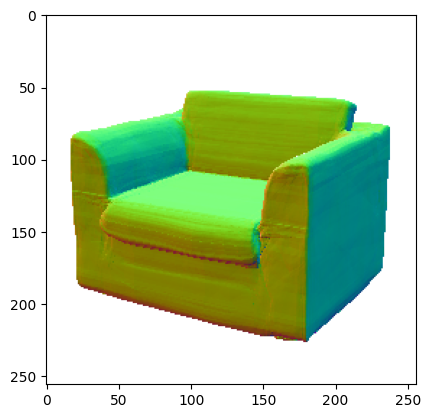

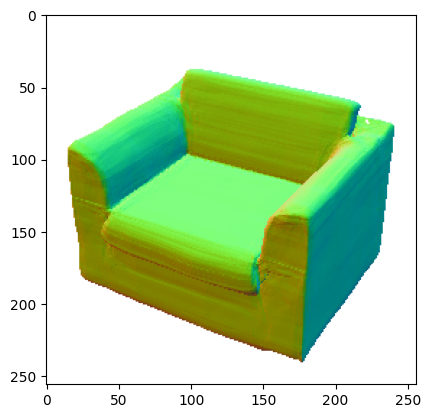

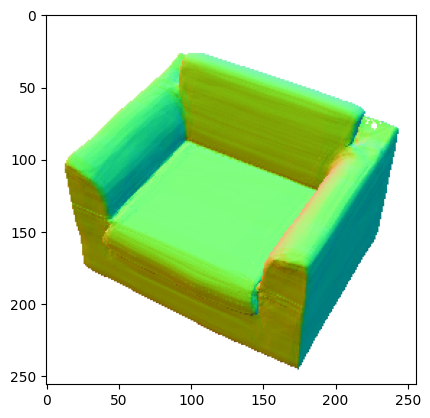

 40%|████      | 12/30 [00:26<00:39,  2.19s/it]


In [46]:
from lib.data.preprocess_sketch import image_to_sketch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

dist = 4
for azim in tqdm(torch.arange(0, 360, 30), total=30):
    for elev in torch.arange(0, -60, -15):
        camera = Camera(azim=azim, elev=elev, dist=dist, sphere_eps=sphere_eps)
        points, rays, mask = camera.unit_sphere_intersection_rays()
        light_position = torch.tensor([1, 1, 0], dtype=torch.float32, device=device)
        surface_points, surface_mask = model.sphere_tracing(
            points=points.to(device),
            rays=rays.to(device),
            mask=mask.to(device),
        )
        normals = model.render_normals(points=surface_points, mask=surface_mask)
        normal_image = visualize_image(model.normal_to_image(normals, surface_mask))
        image = model.render_image(
            points=surface_points,
            mask=surface_mask,
            camera_position=camera.camera_position().to(device),
            light_position=light_position,
        )
        gt_rendered_image = model.to_image(image, surface_mask)
        _img = (gt_rendered_image.detach().cpu().numpy() * 255).astype(np.uint8)
        _sketch = image_to_sketch([_img], t_lower=60, t_upper=100, aperture_size=3, L2gradient=True)[0]
        cv2.imwrite(f"temp/sketches/{azim}-{-elev}-{4}-sketch.png", _sketch)
        cv2.imwrite(f"temp/images/{azim}-{-elev}-{4}-image.png", cv2.cvtColor(gt_rendered_image.detach().cpu().numpy() * 255, cv2.COLOR_RGB2BGR))
        cv2.imwrite(f"temp/normals/{azim}-{-elev}-{4}-normal.png", cv2.cvtColor(normal_image * 255, cv2.COLOR_RGB2BGR))

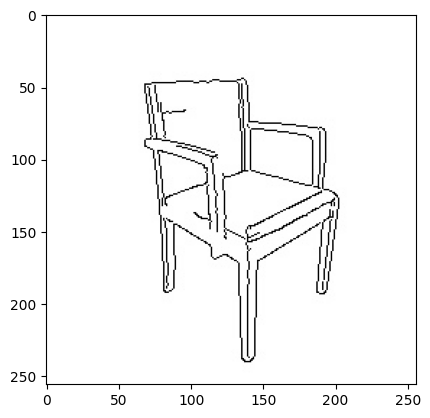

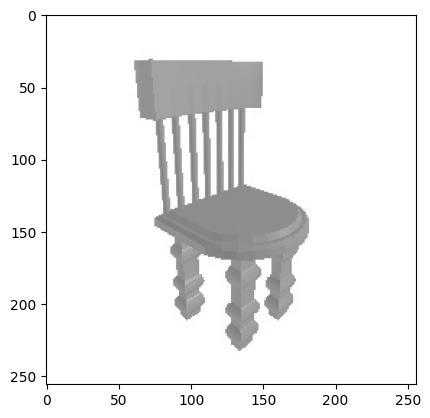

In [259]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from torch.optim import Adam
from torch.nn.functional import normalize
from tqdm import tqdm
from pathlib import Path

path = Path("/home/borth/sketch2shape/data/siamese_chair_large")

def read_image(path: Path, device: str):
    transform = transforms.ToTensor()
    return transform(cv2.imread(str(path))).to(device)

gt_sketch_path = Path(path, "1a6f615e8b1b5ae4dbbc9440457e303e/sketches/00021.jpg")
gt_sketch = read_image(gt_sketch_path, device=device)
plt.imshow(gt_sketch.permute(1, 2, 0).detach().cpu().numpy())
plt.show()

gt_rendered_image_path = Path(path, "fc4d15c15c56aa7baab4888e25356418/images/00021.jpg")
gt_rendered_image = read_image(gt_rendered_image_path, device=device)
plt.imshow(gt_rendered_image.permute(1, 2, 0).detach().cpu().numpy())
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from torch.optim import Adam
from torch.nn.functional import normalize
from tqdm import tqdm

sketch = gt_sketch.clone().detach()
rendered_image = gt_rendered_image[0].clone().detach()
rendered_image.requires_grad = True
# rendered_image *= torch.randn_like(rendered_image)

optimizer = Adam([rendered_image], lr=1e-03)

for step in (pbar := tqdm(range(100))):
    optimizer.zero_grad()
    output = siamese.forward({"sketch": sketch[None], "image": rendered_image.expand(3, 256, 256)[None]})
    sketch_emb = normalize(output["sketch_emb"], dim=-1)
    image_emb = normalize(output["image_emb"], dim=-1)
    emb_loss = -(sketch_emb @ image_emb.T).sum() + 1
    # color_loss = torch.norm(rendered_image - rendered_image.mean(dim=0), p=1) * 0.1

    # loss = color_loss + emb_loss
    loss = emb_loss

    loss.backward()
    optimizer.step()

    # ensures that the image stays in correct values
    with torch.no_grad():
        for param in optimizer.param_groups[0]["params"]:
            param.clamp_(0, 1)

    pbar.set_postfix_str(f"{loss=:.3f}")
    # pbar.set_postfix_str(f"{loss=:.3f}, {emb_loss=:.3f}, {color_loss=:.3f}")
    # if step % 100 == 0:
    #     plt.imshow(rendered_image.permute(1, 2, 0).detach().cpu().numpy())
    #     plt.show()

plt.imshow(gt_sketch.permute(1, 2, 0).detach().cpu().numpy())
plt.show()

plt.imshow(gt_rendered_image.permute(1, 2, 0).detach().cpu().numpy())
plt.show()

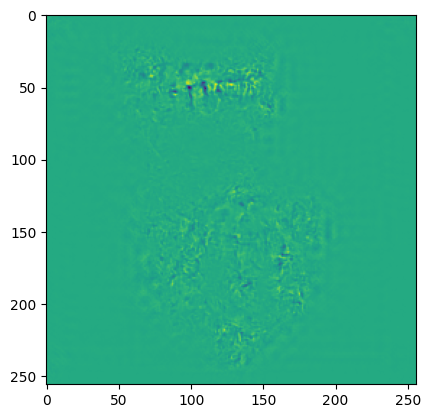

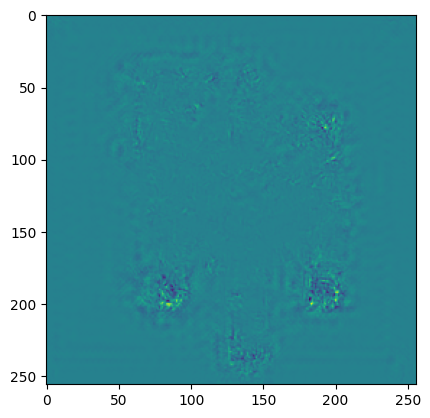

In [261]:
rendered_image = gt_rendered_image[0].clone().detach()
rendered_image.requires_grad = True

sketch = gt_sketch[0].clone().detach()
sketch.requires_grad = True

output = siamese.forward(
    {
        "sketch": sketch.expand(3, 256, 256)[None],
        "image": rendered_image.expand(3, 256, 256)[None],
    }
)
# sketch_emb = normalize(output["sketch_emb"], dim=-1)
# image_emb = normalize(output["image_emb"], dim=-1)
emb_loss = -(output["sketch_emb"] @ output["image_emb"].T).sum()
loss = emb_loss

grad_image = torch.autograd.grad(
    outputs=loss,
    inputs=rendered_image,
    grad_outputs=torch.ones_like(loss),
    retain_graph=True
)[0]

grad_sketch = torch.autograd.grad(
    outputs=loss,
    inputs=sketch,
    grad_outputs=torch.ones_like(loss),
)[0]

plt.imshow(grad_image.detach().cpu().numpy())
plt.show()

plt.imshow(grad_sketch.detach().cpu().numpy())
plt.show()


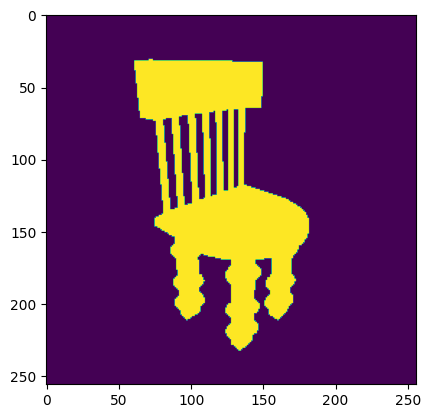

In [262]:
surface_mask = torch.ones_like(rendered_image)
surface_mask[rendered_image > 0.95] = 0
plt.imshow(surface_mask.detach().cpu().numpy())
plt.show()

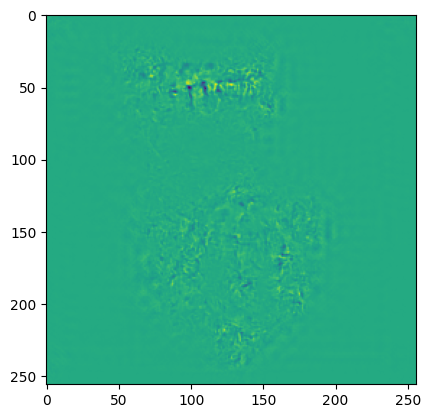

In [263]:
_grad_image = grad_image.clone()
plt.imshow(_grad_image.detach().cpu().numpy())
plt.show()

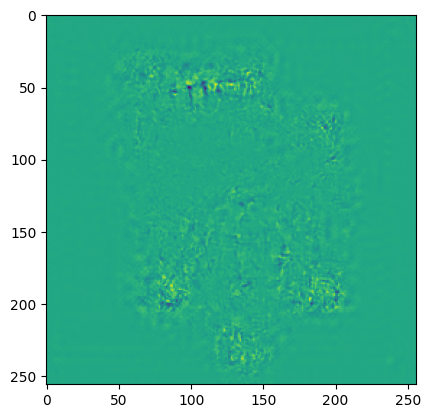

In [264]:
grad_map = grad_image - grad_sketch
img = torch.ones_like(grad_sketch)
# img[] = 0
plt.imshow(grad_map.detach().cpu().numpy())
plt.show()

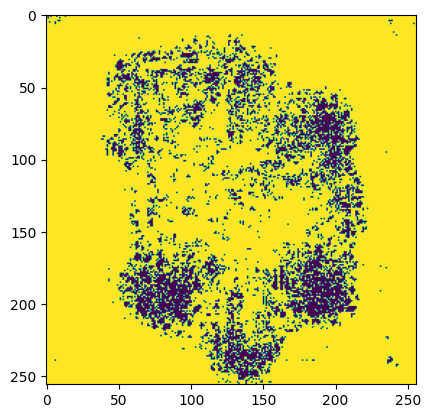

In [208]:
img = torch.ones_like(grad_sketch)
img[torch.abs(grad_sketch)> 0.1] = 0
plt.imshow(img.detach().cpu().numpy())

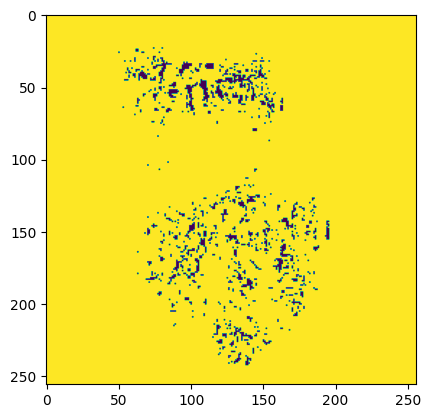

In [268]:
img = torch.ones_like(grad_image)
img[grad_image < -0.2] = 0
plt.imshow(img.detach().cpu().numpy())

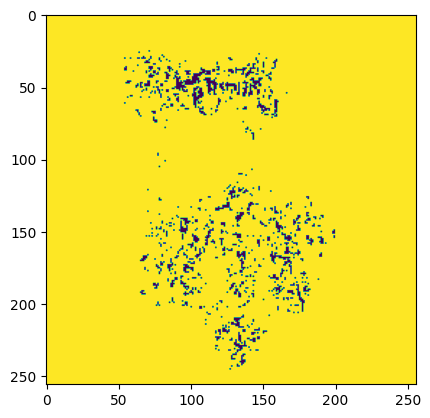

In [269]:
img = torch.ones_like(grad_image)
img[grad_image > 0.2] = 0
plt.imshow(img.detach().cpu().numpy())